In [5]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score, BicScore
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
import networkx as nx
from pgmpy.base import DAG
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [6]:
source_data_path = "./../tcs_stock.csv"
row_df = pd.read_csv(source_data_path)

## Step 1. Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 –target variables, the rest - predictors).

In [7]:
row_df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,TCS,EQ,2558.25,2567.0,2567.00,2541.00,2550.00,2545.55,2548.51,183415,4.674345e+13,8002,52870,0.2883
1,2015-01-02,TCS,EQ,2545.55,2551.0,2590.95,2550.60,2588.40,2579.45,2568.19,462870,1.188740e+14,27585,309350,0.6683
2,2015-01-05,TCS,EQ,2579.45,2581.0,2599.90,2524.65,2538.10,2540.25,2563.94,877121,2.248886e+14,43234,456728,0.5207
3,2015-01-06,TCS,EQ,2540.25,2529.1,2529.10,2440.00,2450.05,2446.60,2466.90,1211892,2.989615e+14,84503,714306,0.5894
4,2015-01-07,TCS,EQ,2446.60,2470.0,2479.15,2407.45,2426.90,2417.70,2433.96,1318166,3.208362e+14,101741,886368,0.6724


#### Target: 
High, Low, Trades
#### Predictors:
Prev Close, Open, Close, VWAP, Volume, Deliverable Volume

In [8]:
df = row_df[['High', 'Low', 'Trades', 'Prev Close', 'Open', 'Close', 'VWAP', 'Volume', 'Deliverable Volume', 'Turnover']]
df.head()

,High,Low,Trades,Prev Close,Open,Close,VWAP,Volume,Deliverable Volume,Turnover
0,2567.00,2541.00,8002,2558.25,2567.0,2545.55,2548.51,183415,52870,4.674345e+13
1,2590.95,2550.60,27585,2545.55,2551.0,2579.45,2568.19,462870,309350,1.188740e+14
2,2599.90,2524.65,43234,2579.45,2581.0,2540.25,2563.94,877121,456728,2.248886e+14
3,2529.10,2440.00,84503,2540.25,2529.1,2446.60,2466.90,1211892,714306,2.989615e+14
4,2479.15,2407.45,101741,2446.60,2470.0,2417.70,2433.96,1318166,886368,3.208362e+14


Distributions:  
High - hypsecant with param 1.0910  
Low - laplace with param 1.3288  
Trades - gumbel_r with param 3.3611

Prev Close- laplace with parameter 7.3622  
Open - laplace with parameter 8.493  
Close - laplace with parameter 7.6574  
VWAP - laplace with parameter 1.1143  
Volume - johnsonsb with parameter 5.2133  
Deliverable Volume - invgamma with parameter 9.9473

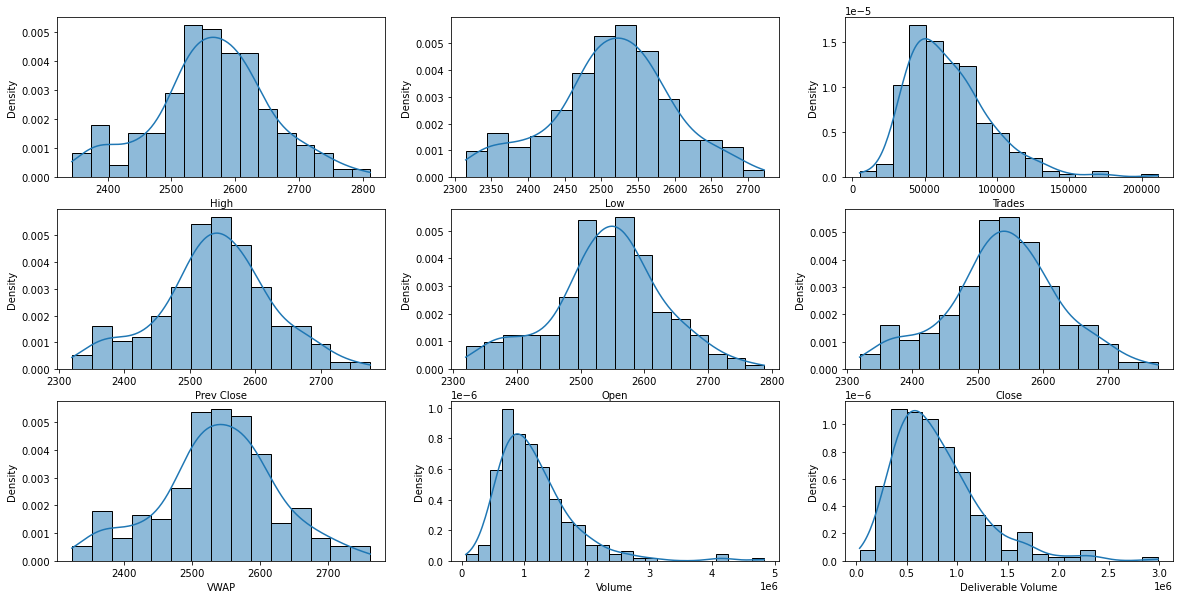

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(20,10))
sns.histplot(df['High'], ax=ax[0,0], kde=True, stat="density")
sns.histplot(df['Low'], ax=ax[0,1], kde=True, stat="density")
sns.histplot(df['Trades'], ax=ax[0,2], kde=True, stat="density")
sns.histplot(df['Prev Close'], ax=ax[1,0], kde=True, stat="density")
sns.histplot(df['Open'], ax=ax[1,1], kde=True, stat="density")
sns.histplot(df['Close'], ax=ax[1,2], kde=True, stat="density")
sns.histplot(df['VWAP'], ax=ax[2,0], kde=True, stat="density")
sns.histplot(df['Volume'], ax=ax[2,1], kde=True, stat="density")
sns.histplot(df['Deliverable Volume'], ax=ax[2,2], kde=True, stat="density")

plt.show()

## Step 2. Using univariate parametric distributions that were fitted in Lab#2 make sampling of chosen target variables. Use for this 2 different sampling methods.

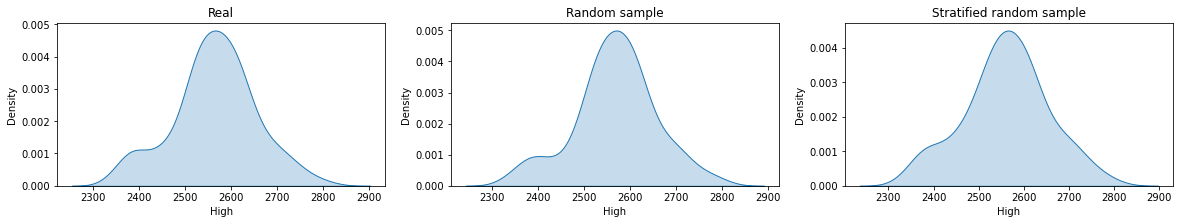

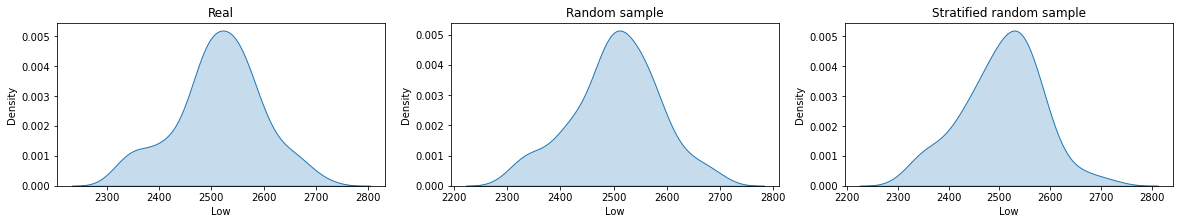

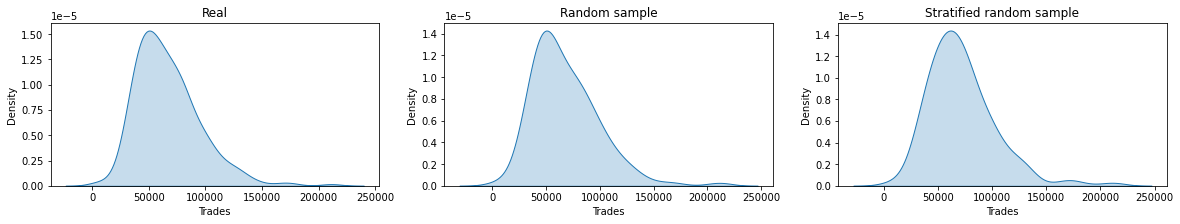

In [10]:
labels =['High', 'Low', 'Trades']

for l in labels:
    fig, axes = plt.subplots(1, 3, figsize=(20, 3))
    sns.kdeplot(ax=axes[0], data=df, x=l, shade=True)

    # Random sample
    sample_data = df.sample(frac=.5)
    sns.kdeplot(ax=axes[1], data=sample_data, x=l, shade=True)

    # Stratified random sample
    mean = df[l].mean()

    sample_data_0 = df[df[l] > mean].sample(n=60, axis=0)
    sample_data_1 = df[df[l] <= mean].sample(n=60, axis=0)
    sample_data = pd.concat([sample_data_0, sample_data_1])
    sns.kdeplot(ax=axes[2], data=sample_data, x=l, shade=True)

    axes[0].set_title('Real')
    axes[1].set_title('Random sample')
    axes[2].set_title('Stratified random sample')
    plt.show()

## Step 3. Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients.

In [11]:
predictors = df[['Prev Close', 'Open', 'Close', 'VWAP', 'Volume', 'Deliverable Volume']]
targets = df[['High', 'Low', 'Trades']]

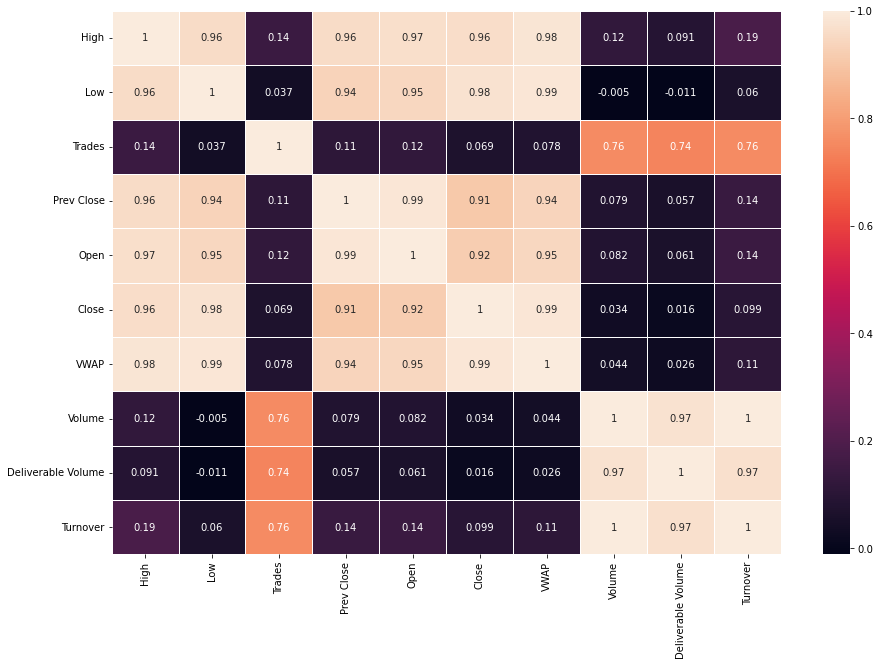

In [12]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(method='spearman'), annot=True, linewidths=.5)
plt.show()

We have got troubles with correlation of Volume and Deliverable Volume. So we will remove this predictors from dataset. Other predictors with ban correlation will be used, because we have small number of columns ¯\\_(ツ)_/¯

Another point - use Trades feature as target. But it has a problem - only Turnover has a great correlation with it. We can check out make decision after all.

In [13]:
df = row_df[['High', 'Low', 'Trades', 'Prev Close', 'Open', 'Close', 'VWAP', 'Turnover']]

## Step 4. Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

In [14]:
df_transformed = df.copy()
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
df_discretized = discretizer.fit_transform(df.values[:])

In [15]:
df_transformed[:] = df_discretized
df_transformed

,High,Low,Trades,Prev Close,Open,Close,VWAP,Turnover
0,4.0,5.0,0.0,5.0,5.0,5.0,5.0,0.0
1,5.0,5.0,1.0,5.0,5.0,5.0,5.0,1.0
2,5.0,5.0,1.0,5.0,6.0,4.0,5.0,2.0
3,3.0,3.0,3.0,4.0,4.0,2.0,3.0,3.0
4,2.0,2.0,4.0,2.0,3.0,2.0,2.0,3.0
...,...,...,...,...,...,...,...,...
243,2.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0
244,2.0,2.0,1.0,2.0,2.0,2.0,3.0,5.0
245,2.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0
246,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [16]:
blacklist = [(x, y) for x in df_transformed.columns.to_list() for y in ['Turnover', 'Trades'] if x != y]

From the structure of the Baess network, we excluded the parameters of Turnover, Trades based on the correlation analysis. These parameters are weakly correlated with the rest, so there is no point in considering them.

## K2Score

In [17]:
hc_search = HillClimbSearch(data=df_transformed)
model_k2 = hc_search.estimate(scoring_method=K2Score(df_transformed), black_list=blacklist, show_progress=False)

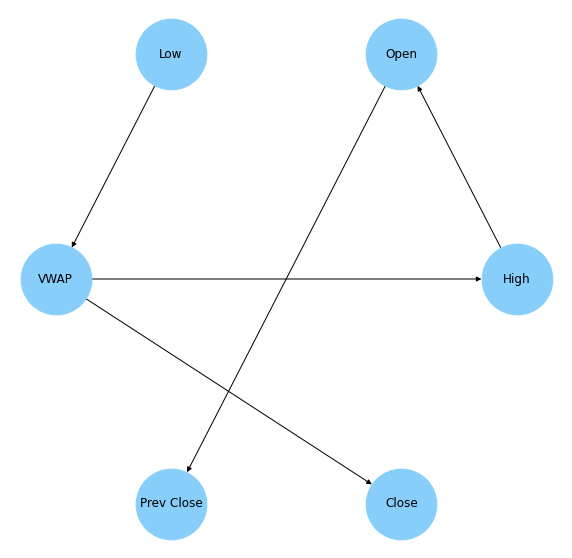

In [18]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(model_k2.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

In [19]:
def accuracy_params_restoration(bn: BayesianNetwork, data: pd.DataFrame):
    bn.fit(data)
    result = pd.DataFrame(columns=['Parameter', 'accuracy'])
    bn_infer = VariableElimination(bn)
    for j, param in enumerate(data.columns):
        accuracy = 0
        test_param = data[param].copy()
        test_data = data.drop(columns=param)
        evidence = test_data.to_dict('records')
        predicted_param = []
        for element in evidence:
            prediction = bn_infer.map_query(variables=[param], evidence=element, show_progress=False)
            predicted_param.append(prediction[param])
        accuracy = accuracy_score(test_param.values, predicted_param)
        result.loc[j,'Parameter'] = param
        result.loc[j, 'accuracy'] = accuracy
    return result


In [20]:
accuracy_params_restoration(BayesianNetwork(model_k2.edges()),
                            df_transformed[['High','Low','Prev Close','Open','Close','VWAP']].sample(frac=0.3))

,Parameter,accuracy
0,High,0.716216
1,Low,0.743243
2,Prev Close,0.824324
3,Open,0.864865
4,Close,0.689189
5,VWAP,0.864865


## Step 5. Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning.

### K2 algorithm implemented above!

## BicScore with stratified random sample

In [45]:
model_bic = hc_search.estimate(scoring_method=BicScore(df_transformed.sample(frac=.8)), black_list=blacklist, show_progress=False)

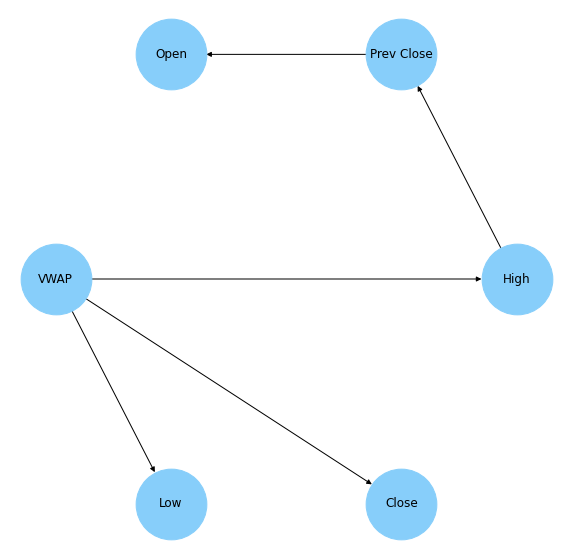

In [46]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(model_bic.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

## BicScore with random sampling

In [54]:
mean = df_transformed[l].mean()

sample_data_0 = df_transformed[df_transformed[l] > mean].sample(n=80, axis=0)
sample_data_1 = df_transformed[df_transformed[l] <= mean].sample(n=80, axis=0)
sample_data = pd.concat([sample_data_0, sample_data_1])

model_bic_2 = hc_search.estimate(scoring_method=BicScore(sample_data), black_list=blacklist, show_progress=False)

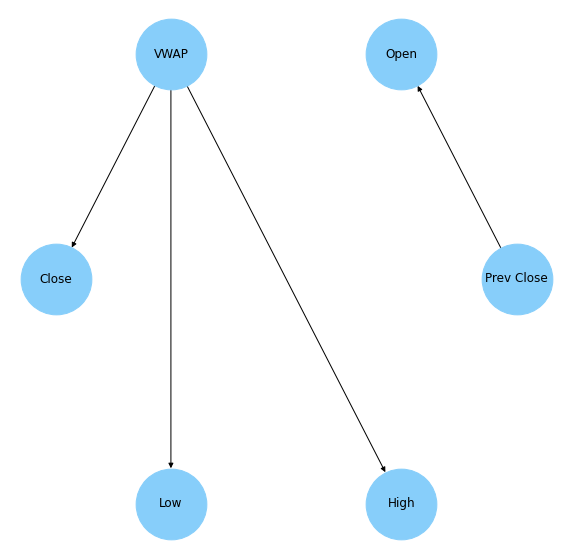

In [55]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(model_bic_2.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

 ## Step 6. Analyze a quality of sampled target variables from the point of view of problem statement (e.g. prediction, gap filling, synthetic generation).

In [23]:
def sampling (bn: DAG, data: pd.DataFrame, n: int = 100):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n)
    return sample

In [24]:
def draw_comparative_hist (parametr: str, original_data: pd.DataFrame, data_sampled: pd.DataFrame, axes=None):
    final_df = pd.DataFrame()
    
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    
    sns.barplot(ax=axes, x=parametr, y="Probability", hue="Data", data=final_df)

In [25]:
sample_K2 = sampling(model_k2, df_transformed, df_transformed.shape[0])
sample_Bic = sampling(model_bic, df_transformed, df_transformed.shape[0])

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

## Quality

In [26]:
print(classification_report(df_transformed['High'], sample_K2['High']))

              precision    recall  f1-score   support

         0.0       0.14      0.12      0.13         8
         1.0       0.08      0.07      0.08        14
         2.0       0.08      0.10      0.09        21
         3.0       0.19      0.16      0.18        49
         4.0       0.25      0.28      0.26        50
         5.0       0.11      0.09      0.10        44
         6.0       0.06      0.07      0.06        30
         7.0       0.10      0.12      0.11        16
         8.0       0.00      0.00      0.00        12
         9.0       0.00      0.00      0.00         4

    accuracy                           0.14       248
   macro avg       0.10      0.10      0.10       248
weighted avg       0.14      0.14      0.14       248



In [27]:
print(classification_report(df_transformed['Low'], sample_K2['Low']))

              precision    recall  f1-score   support

         0.0       0.09      0.08      0.08        13
         1.0       0.00      0.00      0.00        10
         2.0       0.12      0.12      0.12        17
         3.0       0.16      0.20      0.18        25
         4.0       0.18      0.16      0.17        56
         5.0       0.25      0.23      0.24        61
         6.0       0.22      0.24      0.23        34
         7.0       0.10      0.13      0.11        15
         8.0       0.00      0.00      0.00        13
         9.0       0.00      0.00      0.00         4

    accuracy                           0.17       248
   macro avg       0.11      0.12      0.11       248
weighted avg       0.17      0.17      0.17       248



In [30]:
print(classification_report(df_transformed['High'], sample_Bic['High']))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.00      0.00      0.00        14
         2.0       0.00      0.00      0.00        21
         3.0       0.18      0.20      0.19        49
         4.0       0.17      0.14      0.16        50
         5.0       0.17      0.16      0.16        44
         6.0       0.06      0.07      0.06        30
         7.0       0.07      0.06      0.06        16
         8.0       0.07      0.08      0.08        12
         9.0       0.12      0.25      0.17         4

    accuracy                           0.12       248
   macro avg       0.08      0.10      0.09       248
weighted avg       0.12      0.12      0.12       248



In [31]:
print(classification_report(df_transformed['Low'], sample_Bic['Low']))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        13
         1.0       0.00      0.00      0.00        10
         2.0       0.00      0.00      0.00        17
         3.0       0.05      0.04      0.04        25
         4.0       0.25      0.25      0.25        56
         5.0       0.23      0.23      0.23        61
         6.0       0.11      0.12      0.12        34
         7.0       0.06      0.07      0.06        15
         8.0       0.00      0.00      0.00        13
         9.0       0.00      0.00      0.00         4

    accuracy                           0.14       248
   macro avg       0.07      0.07      0.07       248
weighted avg       0.14      0.14      0.14       248



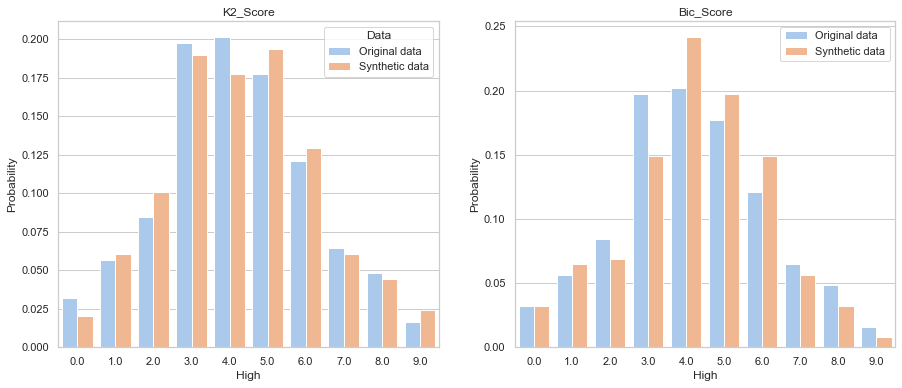

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

draw_comparative_hist('High', df_transformed, sample_K2, axes=axes[0])
draw_comparative_hist('High', df_transformed, sample_Bic, axes=axes[1])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()

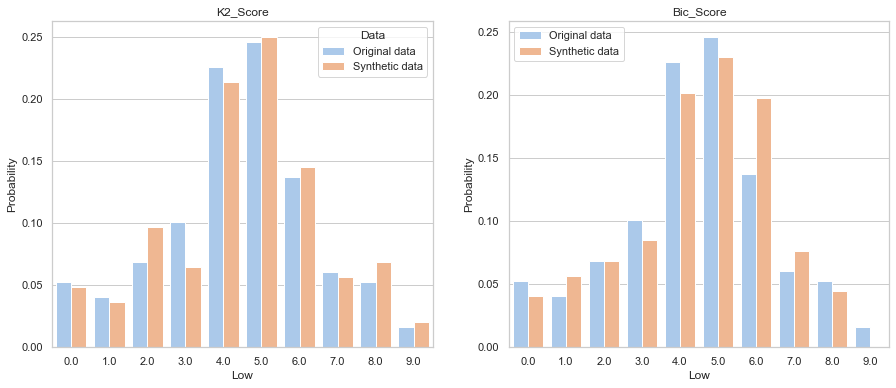

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

draw_comparative_hist('Low', df_transformed, sample_K2, axes=axes[0])
draw_comparative_hist('Low', df_transformed, sample_Bic, axes=axes[1])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()

In [42]:
for in_blacklist in list(set(df_transformed.columns) - set(sample_K2.columns)):
    sample_K2[in_blacklist] = df_transformed[in_blacklist].copy()
    sample_Bic[in_blacklist] = df_transformed[in_blacklist].copy()

In [44]:
sample_K2[sample_K2.columns] = discretizer.inverse_transform(sample_K2[sample_K2.columns].values)
sample_Bic[sample_K2.columns] = discretizer.inverse_transform(sample_Bic[sample_K2.columns].values)

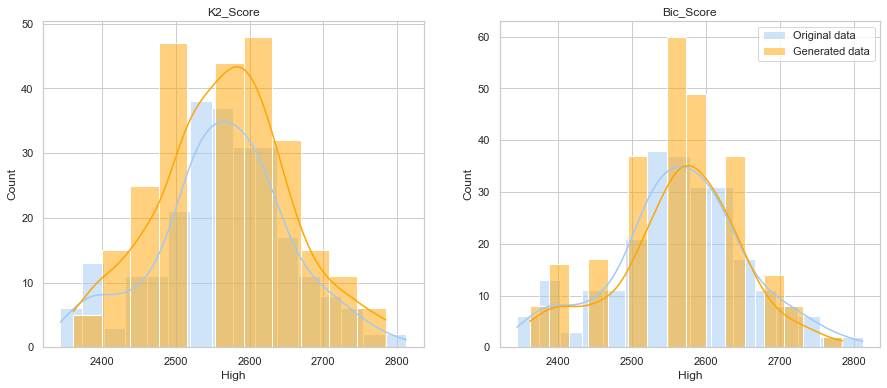

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df['High'], label='Original data', kde=True, ax=axes[0])
sns.histplot(sample_K2['High'], label='Generated data', kde=True, color='orange', ax=axes[0])

sns.histplot(df['High'], label='Original data', kde=True, ax=axes[1])
sns.histplot(sample_Bic['High'], label='Generated data', kde=True, color='orange', ax=axes[1])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()

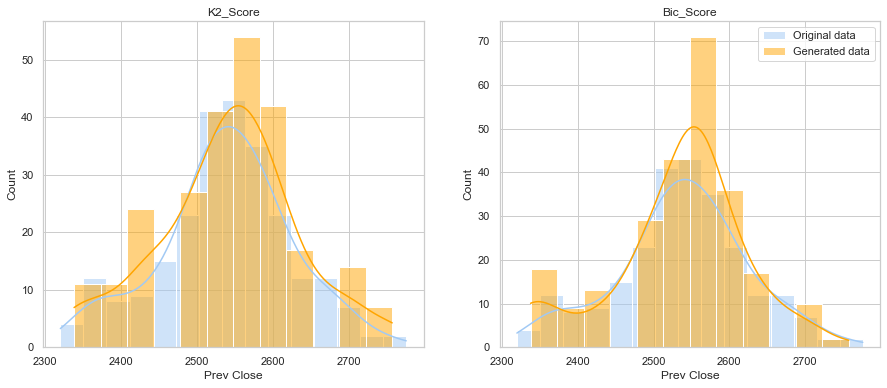

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df['Prev Close'], label='Original data', kde=True, ax=axes[0])
sns.histplot(sample_K2['Prev Close'], label='Generated data', kde=True, color='orange', ax=axes[0])

sns.histplot(df['Prev Close'], label='Original data', kde=True, ax=axes[1])
sns.histplot(sample_Bic['Prev Close'], label='Generated data', kde=True, color='orange', ax=axes[1])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()